## E(n)-GNN for Point Cloud denoising

Will rely heavily on the scheme and utils developed for these examples: https://github.com/lucidrains/geometric-vector-perceptron

In [1]:
import os
import sys
import time
sys.path.append("../../egnn-pytorch/egnn_pytorch")
sys.path.append("../../geometric-vector-perceptron/geometric_vector_perceptron")
sys.path.append("../../geometric-vector-perceptron/examples")

import torch
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# custom model
from egnn_pytorch import *
from geometric_vector_perceptron import *
# custom utils
from data_handler import *
from data_utils import *
# process and dataset
import gc
import joblib
from tqdm import tqdm
from functools import partial

In [2]:
# data
import sidechainnet
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cpu")

In [4]:
### Dataloader for training

In [5]:
# MIN_LEN = 70
MAX_LEN = 100
MAX_PROTS = 360

In [6]:
dataloaders_ = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders_.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
train_examples_storer = [get_prot(dataloader_=dataloaders_, vocab_=VOCAB,
                                  max_len=MAX_LEN, verbose=0) \
                         for i in tqdm(range(MAX_PROTS))]

# dataloaders won't work on my windows (idk why, so load examples from disk and train)
# train_examples_storer = joblib.load("sidechainnet_data/800_under_200.joblib")

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


100%|██████████| 360/360 [00:56<00:00,  6.33it/s]


## Data encoding dims and instantiate model

In [7]:
NEEDED_INFO = {"cutoffs": [1e-5],
               "bond_scales": [1],
               "aa_pos_scales": [1,2,4,8,16,32,64,128],
               "atom_pos_scales": [1,2,4,8,16,32],
               "dist2ca_norm_scales": [1,2,4],
               "bb_norms_atoms": [0.5] # will encode 3 vectors with this
              }
# get model sizes from encoded protein
seq, true_coords, angles, padding_seq, mask = train_examples_storer[-1] 
NEEDED_INFO["seq"] = seq[:-padding_seq]
NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)


# encode as needed
encoded = encode_whole_protein(seq, true_coords, angles, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
x, edge_index, edge_attrs, embedd_info = encoded
# add position coords
cloud_mask = scn_cloud_mask(seq)
cloud_mask[-padding_seq:] = 0.
cloud_mask = cloud_mask.bool()
flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')

x = torch.cat( [ true_coords[flat_cloud_mask], x ], dim=-1 )

### adjust for egnn: 
# 1. remove vectors
# 2. remove scalars for distance
embedd_info["point_n_scalars"] -= 2*len(NEEDED_INFO["aa_pos_scales"])+1
embedd_info["point_n_scalars"] -= 2*len(NEEDED_INFO["atom_pos_scales"])+1
embedd_info["point_n_scalars"] -= 2*len(NEEDED_INFO["dist2ca_norm_scales"])+1
embedd_info["point_n_scalars"] -= 3 * ( 2*len(NEEDED_INFO["bb_norms_atoms"])+1 )
embedd_info["point_n_vectors"] = 0
embedd_info["bond_n_scalars"] -= 2*len(NEEDED_INFO["bond_scales"])+1
embedd_info["bond_n_vectors"] = 0

embedd_info

{'point_n_vectors': 0,
 'point_n_scalars': 2,
 'bond_n_vectors': 0,
 'bond_n_scalars': 1,
 'bond_embedding_nums': [2]}

In [8]:
# define model
model = EGNN_Sparse_Network(n_layers=3,
                            feats_dim=2, pos_dim = 3,
                            edge_attr_dim = 1, m_dim = 16,
                            fourier_features = 2,
                            embedding_nums=[36,20], embedding_dims=[16,16],
                            edge_embedding_nums=[2], edge_embedding_dims=[2],
                            recalc=False, verbose=False)

In [9]:
# calc training sample:
for th_pre in np.linspace(0,1,5):
    th = MIN_LEN + int( th_pre * (MAX_LEN-MIN_LEN) )
    print("under", th, "aas, we have:", sum([len(x[0])<th for x in train_examples_storer]), "proteins")

under 70 aas, we have: 0 proteins
under 77 aas, we have: 0 proteins
under 85 aas, we have: 169 proteins
under 92 aas, we have: 169 proteins
under 100 aas, we have: 360 proteins


### Train

In [10]:
model = model.to(device) # .double()

In [11]:
noise = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
model.train()

# info records
baseline_losses = []
epoch_losses    = []
tac    = time.time()
# training run params
max_seq_len = MAX_LEN # 120
iteration   = 0
n_per_iter  = MAX_PROTS # 400
for ep in range( 2*n_per_iter ): # 1*n_per_iter
    # delete useless data from prev iter - but not in last one
    if ep > 0:
        del true_coords, angles, edge_index, edge_attrs
        del target_coords, pred_coords, base_coords
        del encoded, target_aligned, pred_aligned
        gc.collect()
        
        
    # get model sizes from encoded protein
    seq, true_coords, angles, padding_seq, mask = train_examples_storer[ep % len(train_examples_storer)]
    NEEDED_INFO["seq"] = seq[:-padding_seq]
    NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)
    
    # avoid seqs above limit
    if len(seq) > max_seq_len: 
        continue
        
    # pass to device
    true_coords = true_coords.to(device) # .double()
    angles = angles.to(device)           # .double()

    # encode as needed
    encoded = encode_whole_protein(seq, true_coords, angles, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
    x, edge_index, edge_attrs, embedd_info = encoded
    # add position coords
    cloud_mask = scn_cloud_mask(seq)
    cloud_mask[-padding_seq:] = 0.
    # cloud is all points, chain is all for which we have labels
    chain_mask = (mask.unsqueeze(-1) * cloud_mask)
    flat_chain_mask = rearrange(chain_mask.bool(), 'l c -> (l c)')
    cloud_mask = cloud_mask.bool()
    flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')
    # slice useless norm and vector embeddings
    masked_coords = (true_coords + noise*torch.randn_like(true_coords) )[flat_cloud_mask]
    x = torch.cat( [ masked_coords, x[:, -2:] ], dim=-1 )
    edge_attrs = edge_attrs[:, -1:]
    
    batch = torch.tensor([0 for i in range(x.shape[0])], device=device).long()
    
    # predict
    preds = model.forward(x, edge_index, batch=batch, edge_attr=edge_attrs,
                          recalc_edge=None, verbose = False)
    
    # MEASURE ERROR - format pred and target
    target_coords = true_coords[flat_cloud_mask].clone()
    pred_coords   = preds[:, :3]
    base_coords   = x[:, :3]
    
    # option 2: loss is RMSD on reconstructed coords  // align - sometimes svc fails - idk why
    try:
        pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)

        loss = ( (pred_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean()**0.5 
    except:
        pred_aligned, target_aligned = None, None
        print("svd failed convergence, ep:", ep)
        loss = ( (pred_coords - target_coords)[flat_chain_mask[flat_cloud_mask]]**2 ).mean()**0.5
    # measure error
    loss_base = ((base_coords - target_coords)**2).mean()**0.5 
    # not aligned: # loss = ((pred_coords - target_coords)**2).mean()**0.5 
    
    # back pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # records / prints
    iteration += 1
    epoch_losses.append( loss.item() )
    baseline_losses.append( loss_base.item() )
    if iteration % 10 == 1:
        tic = time.time()
        print("BATCH: {0} / {1}, loss: {2}, baseline_loss: {3}, time: {4}".format(iteration, n_per_iter,
                                                                                  epoch_losses[-1],
                                                                                  baseline_losses[-1],
                                                                                  tic-tac))
        tac = time.time()
        if iteration % n_per_iter == 1:
            print("---------------------------------")

BATCH: 1 / 360, loss: 6.606405258178711, baseline_loss: 1.0352725982666016, time: 0.08521699905395508
---------------------------------
BATCH: 11 / 360, loss: 15.582714080810547, baseline_loss: 1.010358452796936, time: 2.1942389011383057
BATCH: 21 / 360, loss: 8.184795379638672, baseline_loss: 1.0067334175109863, time: 3.5033626556396484
BATCH: 31 / 360, loss: 7.440286636352539, baseline_loss: 1.021034598350525, time: 1.9307160377502441
BATCH: 41 / 360, loss: 7.551443099975586, baseline_loss: 0.970949649810791, time: 2.0991339683532715
BATCH: 51 / 360, loss: 7.243101119995117, baseline_loss: 1.00395667552948, time: 1.9908771514892578
BATCH: 61 / 360, loss: 6.449466228485107, baseline_loss: 0.9736710786819458, time: 1.941542148590088
BATCH: 71 / 360, loss: 5.157331466674805, baseline_loss: 0.9973776340484619, time: 2.0319290161132812
BATCH: 81 / 360, loss: 6.819744110107422, baseline_loss: 0.9950692653656006, time: 1.988171100616455
BATCH: 91 / 360, loss: 5.258970260620117, baseline_los

In [27]:
# 3 epochs more

BATCH: 721 / 360, loss: 1.2129513025283813, baseline_loss: 0.9695263504981995, time: 118.35286402702332
---------------------------------
BATCH: 731 / 360, loss: 12.082486152648926, baseline_loss: 1.0053411722183228, time: 2.062721014022827
BATCH: 741 / 360, loss: 1.7755426168441772, baseline_loss: 1.0124186277389526, time: 3.5884909629821777
BATCH: 751 / 360, loss: 1.8681625127792358, baseline_loss: 0.9930509924888611, time: 1.9255900382995605
BATCH: 761 / 360, loss: 3.455533742904663, baseline_loss: 0.9905223846435547, time: 1.9708399772644043
BATCH: 771 / 360, loss: 1.3864237070083618, baseline_loss: 0.9730919003486633, time: 1.941725730895996
BATCH: 781 / 360, loss: 1.4382203817367554, baseline_loss: 1.0095263719558716, time: 1.9161639213562012
BATCH: 791 / 360, loss: 1.3504148721694946, baseline_loss: 0.9950199127197266, time: 1.9466030597686768
BATCH: 801 / 360, loss: 1.2840662002563477, baseline_loss: 0.9903143048286438, time: 1.9865078926086426
BATCH: 811 / 360, loss: 1.1878622

BATCH: 1501 / 360, loss: 1.2166635990142822, baseline_loss: 0.98711097240448, time: 2.0014190673828125
BATCH: 1511 / 360, loss: 1.0742542743682861, baseline_loss: 1.0295672416687012, time: 1.999392032623291
BATCH: 1521 / 360, loss: 1.0539644956588745, baseline_loss: 1.0000168085098267, time: 1.9424152374267578
BATCH: 1531 / 360, loss: 1.0510984659194946, baseline_loss: 1.0116549730300903, time: 1.9691810607910156
BATCH: 1541 / 360, loss: 1.0790494680404663, baseline_loss: 1.0393500328063965, time: 1.9998149871826172
BATCH: 1551 / 360, loss: 2.428323745727539, baseline_loss: 0.9966872334480286, time: 1.956845998764038
BATCH: 1561 / 360, loss: 1.1719813346862793, baseline_loss: 1.0102087259292603, time: 1.9193909168243408
BATCH: 1571 / 360, loss: 1.0218639373779297, baseline_loss: 0.9975153207778931, time: 1.9160897731781006
BATCH: 1581 / 360, loss: 1.0859746932983398, baseline_loss: 0.9935487508773804, time: 1.8892006874084473
BATCH: 1591 / 360, loss: 1.1087557077407837, baseline_loss: 

In [36]:
# 1 epoch more

BATCH: 1801 / 360, loss: 1.1128262281417847, baseline_loss: 0.9752311110496521, time: 101.00407314300537
---------------------------------
BATCH: 1851 / 360, loss: 1.244847059249878, baseline_loss: 0.9977333545684814, time: 11.522690773010254
BATCH: 1901 / 360, loss: 1.0121318101882935, baseline_loss: 0.9691031575202942, time: 9.739641904830933
BATCH: 1951 / 360, loss: 1.0855216979980469, baseline_loss: 0.9891005158424377, time: 10.056929111480713
BATCH: 2001 / 360, loss: 1.0833067893981934, baseline_loss: 1.0139638185501099, time: 9.90006971359253
BATCH: 2051 / 360, loss: 1.0888464450836182, baseline_loss: 0.9910197257995605, time: 9.798437118530273
BATCH: 2101 / 360, loss: 1.0542317628860474, baseline_loss: 0.9864782094955444, time: 9.525416135787964
BATCH: 2151 / 360, loss: 1.0094636678695679, baseline_loss: 0.9725673794746399, time: 9.498141050338745


In [37]:
# 1 epoch more

BATCH: 2201 / 360, loss: 1.772912859916687, baseline_loss: 1.0040830373764038, time: 34.726120948791504
BATCH: 2251 / 360, loss: 1.0324863195419312, baseline_loss: 1.0107669830322266, time: 9.853826999664307
BATCH: 2301 / 360, loss: 1.0516990423202515, baseline_loss: 1.0241236686706543, time: 9.67061185836792
BATCH: 2351 / 360, loss: 1.0497503280639648, baseline_loss: 0.996516764163971, time: 9.690844058990479
BATCH: 2401 / 360, loss: 1.103281021118164, baseline_loss: 1.0430773496627808, time: 9.727795124053955
BATCH: 2451 / 360, loss: 1.0650486946105957, baseline_loss: 0.9810341000556946, time: 9.726760149002075
BATCH: 2501 / 360, loss: 1.0128096342086792, baseline_loss: 0.998742938041687, time: 9.788908243179321


In [38]:
# 1 epoch more

BATCH: 2551 / 360, loss: 1.2500125169754028, baseline_loss: 0.9770948886871338, time: 20.949636936187744
BATCH: 2601 / 360, loss: 1.037798523902893, baseline_loss: 0.9991073608398438, time: 9.857262134552002
BATCH: 2651 / 360, loss: 0.9921033382415771, baseline_loss: 1.0205858945846558, time: 9.893361806869507
BATCH: 2701 / 360, loss: 2.1222379207611084, baseline_loss: 1.0035388469696045, time: 9.752050876617432
BATCH: 2751 / 360, loss: 0.998673141002655, baseline_loss: 0.9910680651664734, time: 9.46408224105835
BATCH: 2801 / 360, loss: 1.045136570930481, baseline_loss: 1.0125902891159058, time: 9.418736934661865
BATCH: 2851 / 360, loss: 1.2243670225143433, baseline_loss: 0.9974039196968079, time: 9.537666082382202


In [43]:
# 2 epochs more

BATCH: 2901 / 360, loss: 1.0809634923934937, baseline_loss: 0.9800694584846497, time: 114.46995091438293
BATCH: 2951 / 360, loss: 1.0368516445159912, baseline_loss: 1.021433711051941, time: 9.696359872817993
BATCH: 3001 / 360, loss: 1.0135295391082764, baseline_loss: 0.9992131590843201, time: 9.667249202728271
BATCH: 3051 / 360, loss: 1.0016484260559082, baseline_loss: 0.9929747581481934, time: 9.662598848342896
BATCH: 3101 / 360, loss: 1.0113122463226318, baseline_loss: 0.9955801963806152, time: 9.68606424331665
BATCH: 3151 / 360, loss: 0.9954321980476379, baseline_loss: 0.9935275316238403, time: 9.660506963729858
BATCH: 3201 / 360, loss: 1.0330802202224731, baseline_loss: 1.0131409168243408, time: 9.786271810531616
BATCH: 3251 / 360, loss: 2.4894702434539795, baseline_loss: 0.9796046018600464, time: 10.694760084152222
BATCH: 3301 / 360, loss: 1.0221614837646484, baseline_loss: 1.0040225982666016, time: 11.223852157592773
BATCH: 3351 / 360, loss: 1.188303828239441, baseline_loss: 1.00

In [44]:
# expected loss without denoising - recorded inside training loop
np.mean(baseline_losses) 

1.0001375773217942

### Training Plot

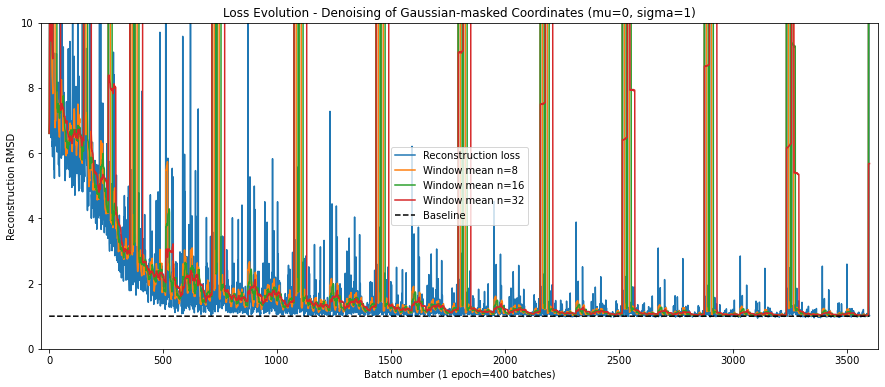

In [52]:
plt.figure(figsize=(15,6))
plt.title("Loss Evolution - Denoising of Gaussian-masked Coordinates (mu=0, sigma=1)")
plt.plot(epoch_losses, label="Reconstruction loss")

for window in [8,16,32]:
    plt.plot([np.mean(epoch_losses[:window][0:i+1]) for i in range(min(window, len(epoch_losses))) ] + \
             [np.mean(epoch_losses[i:i+window+1]) for i in range(len(epoch_losses)-window)], 
             label="Window mean n={0}".format(window))

plt.plot(np.ones(len(epoch_losses)) * np.mean(baseline_losses), "k--", label="Baseline")
    
# plt.yscale("log")
plt.xlim(-0.01*len(epoch_losses),1.01*len(epoch_losses))
plt.ylim(0, 10)
plt.ylabel("Reconstruction RMSD")
plt.xlabel("Batch number (1 epoch=400 batches)")
plt.legend()
plt.show()

### Measure rmsd on (the last trained) reconstructed protein

* Not passing through the model

In [46]:
print("MSE between reconstructed coords: ", ((base_coords - target_coords)**2).mean()**0.5 ) 

MSE between reconstructed coords:  tensor(1.0109)


* passing through the model

In [47]:
# rotate / align
pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)
print("MSE between reconstructed coords: ", ((pred_aligned.t() - target_aligned.t())**2).mean()**0.5 ) 

MSE between reconstructed coords:  tensor(1.0184, grad_fn=<PowBackward0>)


### Make a plot of a reconstructed protein

In [48]:
scaffs  = build_scaffolds_from_scn_angles(seq[:-padding_seq], angles[:-padding_seq].cpu())
wrapper = torch.zeros(*scaffs["cloud_mask"].shape, 3).cpu()
# rebuild target
target_rebuilt = wrapper.clone()
target_rebuilt[scaffs["cloud_mask"].cpu()] = true_coords[:-14*padding_seq][scaffs["cloud_mask"].cpu().view(-1)]
# rebuild encoded-decoded
pre_target_rebuilt = wrapper.clone()
pre_target_rebuilt[scaffs["cloud_mask"].cpu()] = target_coords.cpu()
# build predicted
pred_rebuilt = wrapper.clone()
pred_rebuilt[scaffs["cloud_mask"].cpu()] = pred_coords.cpu()

In [49]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(target_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [50]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(pred_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol